Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])
df_sub = df.copy()

In [0]:
# Split the data in train, validate, and test datasets
df_sub['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
cutoff_trn   = pd.to_datetime('2017-01-01')
cutoff_val_a = pd.to_datetime('2016-12-31')
cutoff_val_b = pd.to_datetime('2018-01-01')
cutoff_tst_a = pd.to_datetime('2017-12-31')
cutoff_tst_b = pd.datetime.today()

In [0]:
# Generate train, validate, and test dataframes by filtering on date
df_train = df_sub[df_sub['Date'] < cutoff_trn]
df_valdt = df_sub[((df_sub['Date'] > cutoff_val_a) & (df_sub['Date'] < cutoff_val_b))]
df_test  = df_sub[((df_sub['Date'] > cutoff_tst_a) & (df_sub['Date'] < cutoff_tst_b))]

In [0]:
# Construct dependent and outcome datasets for the train, validate, and test dataframes
df_train_X = df_train.drop(columns=['Great'])
df_train_y = df_train['Great']

df_valdt_X = df_valdt.drop(columns=['Great'])
df_valdt_y = df_valdt['Great']

df_test_X  = df_test.drop(columns=['Great'])
df_test_y  = df_test['Great']

In [233]:
# Generate Baseline predictions
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# "Fit" the DummyClassifier model
bselne = DummyClassifier(strategy='most_frequent')
bselne.fit(df_train_X, df_train_y)

# Calculate predictions using the validate dataset
tmp_pred_y = bselne.predict(df_valdt_X)
# Score the accuracy of the prediction
acc_valdt = accuracy_score(df_valdt_y, tmp_pred_y)

print(f'The Dummy Classifier model yields an accuracy of: {round(acc_valdt, 4)}')

The Dummy Classifier model yields an accuracy of: 0.5529


In [0]:
# Define a set of simple, intuitive features that may predict the "Great" rating (more accurately than our baseline)
features_intuitive = ['Burrito', 'Cost', 'Hunger', 'Temp', 'Meat', 'Fillings']
target = ['Great']

In [235]:
# Prepare a logistic regression modeling approach
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

train_X = df_train_X[features_intuitive]
train_y = df_train_y

val_X   = df_valdt_X[features_intuitive]
val_y   = df_valdt_y

test_x  = df_test_X[features_intuitive]
test_y  = df_test_y
print(train_X.shape, val_X.shape, test_x.shape)

(298, 6) (85, 6) (37, 6)


In [236]:
# Encode categorical data as binary data columns
encdr = ce.OneHotEncoder(use_cat_names=True)
train_X_encded = encdr.fit_transform(train_X)
val_X_encded   = encdr.transform(val_X)
test_X_encded  = encdr.transform(test_x)
print(train_X_encded.shape, val_X_encded.shape, test_X_encded.shape)

(298, 10) (85, 10) (37, 10)


In [0]:
# Impute missing data values using the one hot encoded data as input
imptr = SimpleImputer(strategy='mean')
train_X_imptd = imptr.fit_transform(train_X_encded)
val_X_imptd   = imptr.transform(val_X_encded)
test_X_imptd  = imptr.transform(test_X_encded)

In [0]:
# Scale the feature data values in using a standard method feeding the imputed data as input
sclr = StandardScaler()
train_X_scaled = sclr.fit_transform(train_X_imptd)
val_X_scaled   = sclr.transform(val_X_imptd)
test_X_scaled  = sclr.transform(test_X_imptd)

In [239]:
# Stand up a logistic modeling object
mdl = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
# Fit the model using the scaled training independent variables and the training outcome value
mdl.fit(train_X_scaled, train_y)

# Calculate the accuracy using the validation data
print(f'The Validation Accuracy is: {round(mdl.score(val_X_scaled, val_y), 4)}')

The Validation Accuracy is: 0.8824


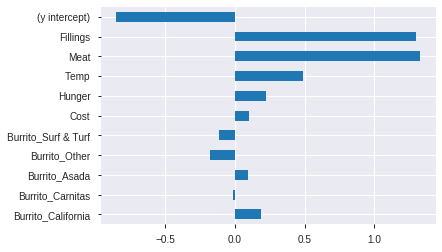

In [240]:
# Render the regression expression terms (coefficients, variables, and intercept)
%matplotlib inline
coefficients = pd.Series(mdl.coef_[0], train_X_encded.columns)
coefficients.sort_values()

tmp_series = pd.Series([mdl.intercept_[0]], ['(y intercept)'])
coefficients = coefficients.append(tmp_series)
coefficients.plot.barh();

In [241]:
# Produce the score of the test data prediction
print(f'The Test Accuracy is: {round(mdl.score(test_X_scaled, test_y), 4)}')

The Test Accuracy is: 0.6757
